## Temperature Simulation Module - Introduction

##### This notebook will introduce users to the Temperature Simulation Module TSM and familiarize them with the module architecture, inputs, and outputs. It will demonstrate how different types of variables are defined and then connected to the module's computational engine. TSM is built in an object-oriented framework. The module engine, which calculates the temperature change for a given timestep, is based on a parent-class titled `Model`. Module inputs are class attributes, and functions that update the input values are class methods.

##### These modules are designed to compute fluxes for a single computation cell, which is assumed to be completely homogeneous. The dimensions of the cell, such as depth, volume, and surface area, are defined in this example as inputs for the modules. When implemented with a hydrodynamic model, cell dimensions will be pulled from the hydrodynamic model.   

## Installation and Setup



## Import Python Dependancies

This step will load in the entire clearwater modules library, which has all the source code necessary to run the modules, including the various python dependencies used to make the calculations, such as numpy and xarray.  

In [8]:
import clearwater_modules as cwm
import clearwater_modules.sorter as sorter
import random
import warnings
warnings.filterwarnings("ignore")

### If you get `ModuleNotFoundError`:

If you get this error:
```python
ModuleNotFoundError: No module named 'clearwater_modules'
```
Then:
1. Run the following terminal command with your local absolute path to this repo.
    - NOTE: Here we use Jupyter `!` magic command to run from the terminal via this notebook. 
2. Restart the kernel.
3. Rerun the import statements above.

See [4. Add your `ClearWater-modules-python` Path to Miniconda/Anaconda sites-packages](..ReadMe.md#4-add-your-clearwater-modules-python-path-to-minicondaanaconda-sites-packages).

Importing the `clearwater_modules` repository will automatically run the `base.py` file that defines the `Model` class. It will also define a child of that class called the `EnergyBudget` class, which is defined in the `model.py` file. This class has the same functionality of the general `Model` class, but has attributes and methods for the expected inputs for TSM. The TSM inputs are broken down into two dictionaries, which are titled `Meteorological` and `Temperature`. The `EnergyBudget` class intitializes the TSM inputs with default values and sets them as class attributes for instances of the `EnergyBudget` class.

The default TSM values are defined in the TSM `constants.py` file, which is imported with `cwm`. Run the following cell to make sure that the TSM subfolder from the `clearwater_modules` repository successfully imports. 

In [9]:
# Confirm that tsm sub-modules are imported
dir(cwm.tsm)

['EnergyBudget',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'constants',
 'dynamic_variables',
 'model',
 'processes',
 'state_variables',
 'static_variables']

Run the following cell to view the default values for the TSM constants. 

In [10]:
print("Default Temperature Constants:")
print(cwm.tsm.constants.DEFAULT_TEMPERATURE)
print("Default Meteorological Constants:")
print(cwm.tsm.constants.DEFAULT_METEOROLOGICAL)


Default Temperature Constants:
{'stefan_boltzmann': 5.67e-08, 'cp_air': 1005, 'emissivity_water': 0.97, 'gravity': 9.806, 'a0': 6984.505294, 'a1': -188.903931, 'a2': 2.133357675, 'a3': -0.01288581, 'a4': 4.39359e-05, 'a5': -8.02392e-08, 'a6': 6.13682e-11, 'pb': 1600, 'cps': 1673, 'h2': 0.1, 'alphas': 0.0432, 'richardson_option': True}
Default Meteorological Constants:
{'air_temp_c': 20, 'q_solar': 400, 'sed_temp_c': 5, 'eair_mb': 1, 'pressure_mb': 1013, 'cloudiness': 0.1, 'wind_speed': 3, 'wind_a': 0.3, 'wind_b': 1.5, 'wind_c': 1, 'wind_kh_kw': 1}


Similar to the module-engine, the input variables are defined as class instances. These instances are defined in the `static_variables.py` file. Whereas the Temperature and Meteorological dictionaries set the actual values for the TSM inputs, the static variable class instances define how these values will be passed around in the model. As suggested by the word static, once set by the dictionaries, the values do not change throughout the model run. Run the code below to view the static variables used in the TSM module. You will notice that `static_variables.py` has definitions for all the variables assigned values by the Temperature and Meteorological dictionaries. You will also see at the top of the file a decorator above the class definition that calls a function called `register_variable`. This function links these variables to the `EnergyBudget` model.       

In [11]:
import sys
import os

current_location = sys.path[0]
static_variables_file = os.path.dirname(os.path.dirname(current_location)) + '\src\clearwater_modules\\tsm\static_variables.py'

with open(static_variables_file) as f:
    print(f.read())

import clearwater_modules.base as base
from clearwater_modules.tsm.model import EnergyBudget


@base.register_variable(models=EnergyBudget)
class Variable(base.Variable):
    ...
# TODO: verify all these values


Variable(
    name='use_sed_temp',
    long_name='Use Sediment Temperature?',
    units='boolean',
    description='Controls whether to use/calculate sediment temperature or not.',
    use='static',
)

Variable(
    name='stefan_boltzmann',
    long_name='Stefan-Boltzmann Constant',
    units='W m-2 K-4',
    description='The Stefan-Boltzmann constant.',
    use='static',
)

Variable(
    name='cp_air',
    long_name='Specific Heat Capacity of Air',
    units='J kg-1 K-1',
    description='The specific heat capacity of air.',
    use='static',
)

Variable(
    name='emissivity_water',
    long_name='Emissivity of Water',
    units='1',
    description='The emissivity of water.',
    use='static',
)

Variable(
    name='gravity',
    long_name='Gravity',
    units='m s-2',
    

The `state_variables.py` file instatiates the variable for water temperature (`TwaterC`), surface area, and volume. The state variables are treated differently because their values will be updated at every computational timestep. These variables are designed to be passed back and forth between the TSM module and a hydrodynamic model, and their values will change at every timestep based on the transport taking place in the linked hydrodynamic model. For `TwaterC`, the value will also change based on computations made in `clearwater_modules`. As stated previously, this example notebook will provide inputs for these variables in a dictionary in order to run the model. However, the dictionary inputs are a simplification of linking to external models. Run the code below to view the state variable file. Notice that the state variables are linked to the `EnergyBudget` model using the decorator function. Also notice that the state variable instances have a property called `process`. This property allows the value of the variable instance to be updated using a function that shares the name of what is set equal to the `process` property.    

In [12]:
import sys
import os

current_location = sys.path[0]
state_variables_file = os.path.dirname(os.path.dirname(current_location)) + '\src\clearwater_modules\\tsm\state_variables.py'

with open(state_variables_file) as f:
    print(f.read())

import xarray as xr
from clearwater_modules import base
from clearwater_modules.tsm.model import EnergyBudget
from clearwater_modules.tsm import processes


@base.register_variable(models=EnergyBudget)
class Variable(base.Variable):
    """TSM state variables."""
    ...

Variable(
    name='water_temp_c',
    long_name='Water temperature',
    units='degC',
    description='TSM state variable for water temperature',
    use='state',
    process=processes.t_water_c,
)

# TODO: remove mock_equation

def mock_surface_area(surface_area: xr.DataArray) -> xr.DataArray:
    return surface_area

def mock_volume(volume: xr.DataArray) -> xr.DataArray:
    return volume


Variable(
    name='surface_area',
    long_name='Surface area',
    units='m^2',
    description='Surface area',
    use='state',
    process=mock_surface_area,
)
Variable(
    name='volume',
    long_name='Volume',
    units='m^3',
    description='Volume',
    use='state',
    process=mock_volume,
)



The `processes.py` file contains all of the functions required to compute the heat flux of a single cell. This is where the process functions that update the state variables are defined. However, there are many intermediate process functions that must be computed before calculating the water temperature change. These intermediate functions calculate `dynamic_variables`, which are used to calculate components of heat flux, which are ultimately added together to compute a total net heat flux. The total net heat flux is then used to compute the water temperature change. The graphic below shows the components of heat flux that are calculated in this module:     

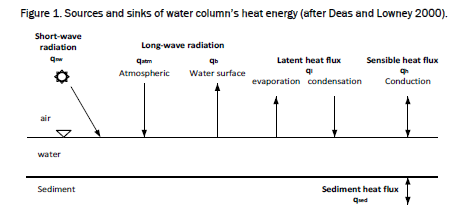

Run the code below to view all the process functions that are required to compute the total net heat flux and water temperature change.

In [13]:
import sys
import os

current_location = sys.path[0]
processes_file = os.path.dirname(os.path.dirname(current_location)) + '\src\clearwater_modules\\tsm\processes.py'

with open(processes_file) as f:
    print(f.read())

"""JIT compiled processes for the heat model."""
import warnings
import numba
import numpy as np
import xarray as xr
from clearwater_modules.shared.processes import (
    celsius_to_kelvin,
)


@numba.njit
def air_temp_k(
    air_temp_c: xr.DataArray,
) -> xr.DataArray:
    """Calculate air temperature (K).

    Args:
        air_temp_c: Air temperature (C)
    """
    return celsius_to_kelvin(air_temp_c)


@numba.njit
def water_temp_k(
    water_temp_c: xr.DataArray,
) -> xr.DataArray:
    """Calculate water temperature (K).

    Args:
        water_temp_c: Water temperature (C)
    """
    return celsius_to_kelvin(water_temp_c)


@numba.njit
def mixing_ratio_air(
    eair_mb: xr.DataArray,
    pressure_mb: xr.DataArray,
) -> xr.DataArray:
    """Calculate air mixing ratio (unitless).

    Args:
        eair_mb: Vapour pressure of air (mb)
        pressure_mb: Atmospheric pressure (mb)
    """
    return 0.622 * eair_mb / (pressure_mb - eair_mb)


@numba.njit
def density_air(
    pres

Dynamic variables are computed by the process functions and then used as inputs to subsequent processes until the new `TwaterC` has been calculated. These variables are defined similarly to state variables. They are instances of a class `Variable` that gets registered to the `EnergyBudget` model, and have a `process` property that links them to a function which defines their value. Unlike static and state variables, dynamic variables do not need initial values, and are not designed to get passed outside of a module computation step. In the model implementation, there is an option to track or not track dynamic variables in memory. The default is to track dynamic variable values, which can be useful for seeing which components have the strongest influence on the overall temperature flux. Run the code below to inspect the dynamic variables used to calculate the water temperature change for `TSM`.     

In [14]:
import sys
import os

current_location = sys.path[0]
dynamic_variables_file = os.path.dirname(os.path.dirname(current_location)) + '\src\clearwater_modules\\tsm\dynamic_variables.py'

with open(dynamic_variables_file) as f:
    print(f.read())

import clearwater_modules.shared.processes as shared_processes
from clearwater_modules import base
from clearwater_modules.tsm.model import EnergyBudget
from clearwater_modules.tsm import processes


@base.register_variable(models=EnergyBudget)
class Variable(base.Variable):
    ...


Variable(
    name='air_temp_k',
    long_name='Air temperature',
    units='K',
    description='Air temperature',
    use='dynamic',
    process=processes.air_temp_k,
)
Variable(
    name='water_temp_k',
    long_name='Water temperature',
    units='K',
    description='Water temperature',
    use='dynamic',
    process=processes.water_temp_k,
)
Variable(
    name='mixing_ratio_air',
    long_name='Mixing ratio of air',
    units='unitless',
    description='Mixing ratio of air',
    use='dynamic',
    process=processes.mixing_ratio_air,
)
Variable(
    name='density_air',
    long_name='Density of air',
    units='kg/m^3',
    description='Density of air',
    use='dynamic',
    process=processes.densi

The order in which dynamic variables must be calculated is determined by the `sorter.py` file defined in the main folder of the `clearwater_modules` repository. This file inspects the arguments for each process function, and checks if these arguments are available in the list of module inputs (static variables with default values, or state variables) or if the arguments are computed during the module run (dynamic variables). The sorter will then put the processes in order to ensure that each process will have all its input arguments defined prior to being called. The `sorter.py` file is called when the module is run. 

Now that the different types of module variables and processes have been defined, we can set up an example module, and run one timestep. To do so, we must create an instance of the `EnergyBudget` model-class that has our desired model inputs. There are a few other options that we set when instatiating the model-class. First, we must determine the number of timesteps we plan to run, by defining the `time_steps` attribute. This is done to improve module computation performance. The size of each timestep is not explicitly defined, and assumed to equal 1 second, but is another variable that should be pulled from the linked hydrodynamic model. Second, we define the initial values for the state variables and static variables (meteorologic and temperature) using dictionaries. The state variables must have initial values provided upon instantiation of the `EnergyBudget` model. Static variables have default values that will be used if no dictionary is provided upon instantiation. Finally, a few computation options need to be defined. These are `track_dynamic_variables`, a boolean attribute which controls whether or not we want to save the value of dynamic variables for each timestep, `hotstart_dataset`, which is another way to initialize `EnergyBudget` using precomputed variables NOT CLEAR IF FUNCTIONING**, and an attribute called `time_dim`, which is the name of the time dimension. Run the codeblock below to instantiate an `EnergyBudget` model. 

In [15]:
initial_state_values = {'water_temp_c': 20, 'surface_area': 1, 'volume': 1}
meteo_parameters = {
    'air_temp_c': 20,
    'q_solar': 400,
    'sed_temp_c': 5,
    'eair_mb': 1,
    'pressure_mb': 1013,
    'cloudiness': .1,
    'wind_speed': 3,
    'wind_a': .3,
    'wind_b': 1.5,
    'wind_c': 1,
    'wind_kh_kw': 1
}

temp_parameters = {
    'use_sed_temp': False,
    'stefan_boltzmann': 0.0000000567,
    'cp_air': 1005,
    'emissivity_water': 0.97,
    'gravity': 9.806,
    'a0': 6984.505294,
    'a1': -188.903931,
    'a2': 2.133357675,
    'a3': -0.01288581,
    'a4': 0.0000439359,
    'a5': -.0000000802392,
    'a6': .0000000000613682,
    'pb': 1600,
    'cps': 1673,
    'h2': 0.1,
    'alphas': 0.0432,
    'richardson_option': True
}

time_step = 1

tsm_model = cwm.tsm.EnergyBudget(
    time_steps=time_step,
    initial_state_values=initial_state_values,  # mandatory
    temp_parameters=temp_parameters,
    meteo_parameters=meteo_parameters,
    track_dynamic_variables=True,  # default is true
    hotstart_dataset=None,  # default is None
    time_dim='Seconds',  # default is "timestep"
)

Initializing from dicts...
Model initialized from input dicts successfully!.


The `tsm_model` instance that we define above has all the information we need to compute the change in water temperature given the conditions we have defined. Run the code below to view the x-array data structure that holds all of this information. The x-array structure displays the dimensions of data that we are tracking. Since there is only one computation cell, we only see one entry for the x and y dimension respectively. We set our `time_steps` = 1, which is reflected by the two entries in the Seconds dimension: the values for the initial conditions, and the values of the tracked variables after that 1 timestep is run. Expand `Data variables` to view the state, static, and dynamic variables. Since this dataset reflects initial conditions before a timestep has been run, you will see `nan` values entered as placeholders for the dynamic variables and for the second column of state variables. There is only one column of data for static variables, as these to do not change over the timesteps.  

In [16]:
tsm_model.dataset

<xarray.Dataset>
Dimensions:            (Seconds: 2, x: 1, y: 1)
Coordinates:
  * Seconds            (Seconds) int32 0 1
  * x                  (x) float64 1.0
  * y                  (y) float64 1.0
Data variables: (12/52)
    water_temp_c       (Seconds, x, y) float64 20.0 nan
    surface_area       (Seconds, x, y) float64 1.0 nan
    volume             (Seconds, x, y) float64 1.0 nan
    use_sed_temp       (x, y) bool True
    stefan_boltzmann   (x, y) float64 5.67e-08
    cp_air             (x, y) int32 1005
    ...                 ...
    q_sediment         (Seconds, x, y) float64 nan nan
    dTdt_sediment_c    (Seconds, x, y) float64 nan nan
    q_net              (Seconds, x, y) float64 nan nan
    q_longwave_down    (Seconds, x, y) float64 nan nan
    q_longwave_up      (Seconds, x, y) float64 nan nan
    dTdt_water_c       (Seconds, x, y) float64 nan nan

Run the `increment_timestep` method to compute the updated water temperature.  The updated values are shown in the second column of the x-array dataset. Since the timestep size is one second, the change in water temperature is quite small. Click the icon that looks like 3 stacked discs labled "View/Hide data repr" to view the updated water temperature unrounded. 

In [17]:
tsm_model.increment_timestep()
tsm_model.dataset

<xarray.Dataset>
Dimensions:            (Seconds: 2, x: 1, y: 1)
Coordinates:
  * Seconds            (Seconds) int32 0 1
  * x                  (x) float64 1.0
  * y                  (y) float64 1.0
Data variables: (12/52)
    water_temp_c       (Seconds, x, y) float64 20.0 20.0
    surface_area       (Seconds, x, y) float64 1.0 1.0
    volume             (Seconds, x, y) float64 1.0 1.0
    use_sed_temp       (x, y) bool True
    stefan_boltzmann   (x, y) float64 5.67e-08
    cp_air             (x, y) int32 1005
    ...                 ...
    q_sediment         (Seconds, x, y) float64 nan -401.5
    dTdt_sediment_c    (Seconds, x, y) float64 nan 129.6
    q_net              (Seconds, x, y) float64 nan -151.1
    q_longwave_down    (Seconds, x, y) float64 nan 337.8
    q_longwave_up      (Seconds, x, y) float64 nan 406.2
    dTdt_water_c       (Seconds, x, y) float64 nan -3.619e-05